# Network Clustering

In this section, we show how PyPSA can deal with spatial clustering of networks. We first load the SciGRID example network and reduce it to standard attributes as otherwise the clustering does not work.

The important information needed for spatial clustering is in the `busmap`. This `pandas.Series` contains the mapping of which buses from the unclustered network should be grouped together, similar to the `groupby` argument known from `pandas`.

You can either calculate a `busmap` from the provided **clustering algorithms** or you can provide your **own busmap**.

In [453]:
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

import pypsa

crs = ccrs.LambertConformal(
    central_longitude=10, central_latitude=51, standard_parallels=(47, 55)
)

kwargs = {"boundaries": [6, 15, 47, 55]}

n = pypsa.examples.scigrid_de()

n.calculate_dependent_values()
n.lines = n.lines.reindex(columns=n.components["Line"]["attrs"].index[1:])
n.lines["type"] = "Al/St 240/40 2-bundle 220.0"
n.buses = n.buses.reindex(columns=n.components["Bus"]["attrs"].index[1:])
n.buses["frequency"] = 50

INFO:pypsa.network.io:New version 0.35.2 available! (Current: 0.35.1)
INFO:pypsa.network.io:Imported network 'SciGrid-DE' has buses, carriers, generators, lines, loads, storage_units, transformers


## Custom Clustering

Let's start with creating an own busmap. Suppose we want to cluster by federal states.
Using `geopandas` we can achieve this by spatially joining the bus coordinates with a `geopandas.GeoDataFrame` containing the federal state boundaries.
Here, we use the function `.sjoin_nearest()` with an appropriate projection ("EPSG:3035") as some buses are located near the borders of federal states in neighbouring countries.


<Axes: >

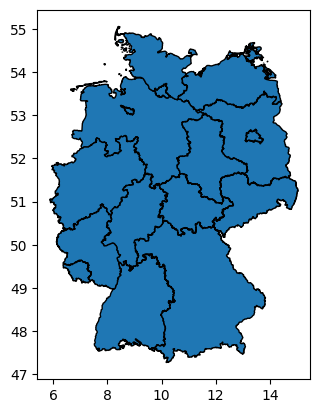

In [454]:
url = "https://media.githubusercontent.com/media/wmgeolab/geoBoundaries/9469f09592ced973a3448cf66b6100b741b64c0d/releaseData/gbOpen/DEU/ADM1/geoBoundaries-DEU-ADM1-all.zip"
states = gpd.read_file(url, layer="geoBoundaries-DEU-ADM1_simplified")
states.plot(edgecolor="k")

In [455]:
bus_coords = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(n.buses.x, n.buses.y, crs=4326), index=n.buses.index
)
busmap = bus_coords.to_crs(3035).sjoin_nearest(states.to_crs(3035), how="left").shapeISO
busmap.head(10)

name
1     DE-NI
2     DE-NI
3     DE-NI
4     DE-NI
5     DE-NI
6     DE-NI
7     DE-NI
8     DE-SH
9     DE-NI
10    DE-BB
Name: shapeISO, dtype: object

Now we cluster the network based on the busmap.

In [456]:
cluster = n.cluster.get_clustering_from_busmap(busmap)

`cluster` is a [`Clustering`][pypsa.clustering.spatial.Clustering] object which contains the `cluster.busmap`, the derived `cluster.linemap` (mapping of parallel lines to aggregate), and the clustered network `cluster.n`.

Let's compare the original to the clustered network topology:

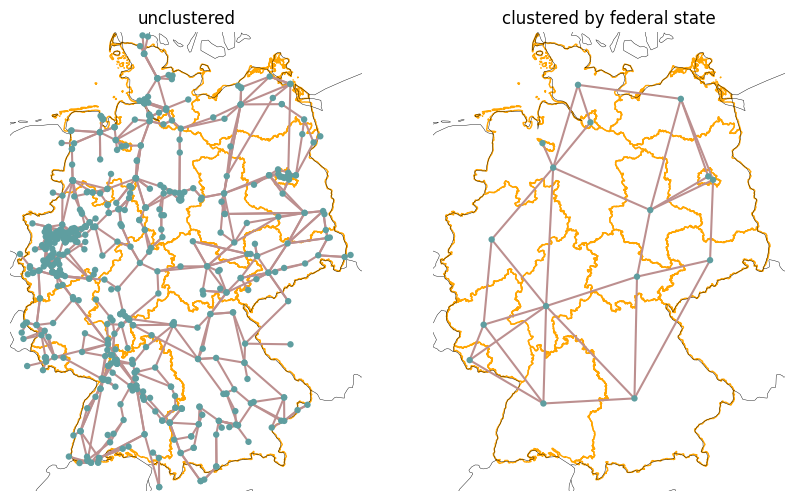

In [457]:
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": crs}, figsize=(10, 7))
for ax in axs:
    states.to_crs(crs.proj4_init).plot(ax=ax, edgecolor="orange", facecolor="none")
n.plot(ax=axs[0], title="unclustered", bus_sizes=0.005, **kwargs)
cluster.n.plot(ax=axs[1], title="clustered by federal state", bus_sizes=0.005, **kwargs);

With the default settings of `get_clustering_from_busmap()`, the attached components are **not** aggregated. That means, for example, for every generator, only the `bus` it attaches to is changed to the respective new clustered bus.

In [458]:
cluster.n.generators.query("bus=='DE-HB'")[["p_nom", "carrier"]]

,p_nom,carrier
name,,
61_220kV Gas,334.000000,Gas
61_220kV Hard Coal,350.000000,Hard Coal
62 Hard Coal,119.000000,Hard Coal
62 Run of River,9.900000,Run of River
62 Waste,44.000000,Waste
67 Gas,14.800000,Gas
67 Hard Coal,300.000000,Hard Coal
67 Oil,88.000000,Oil
67 Other,150.000000,Other


When clustering of attached components to one representative generator per `carrier` is desired, the `aggregate_one_ports` option can be used. For instance, to cluster generators to one representative generator per `carrier` and `bus` run:

In [459]:
cluster = n.cluster.get_clustering_from_busmap(busmap, aggregate_one_ports={"Generator"})
cluster.n.generators.query("bus=='DE-HB'")[["p_nom", "carrier"]]

,p_nom,carrier
name,,
DE-HB Gas,348.800000,Gas
DE-HB Hard Coal,769.000000,Hard Coal
DE-HB Oil,88.000000,Oil
DE-HB Other,150.000000,Other
DE-HB Run of River,9.900000,Run of River
DE-HB Solar,129.495682,Solar
DE-HB Storage Hydro,392.000000,Storage Hydro
DE-HB Waste,77.000000,Waste
DE-HB Wind Onshore,328.926054,Wind Onshore


If only some carriers should be aggregated, this can be controlled with the `aggregate_generators_carriers` option. For example, to aggregate wind, solar and hard coal, run:

In [460]:
cluster = n.cluster.get_clustering_from_busmap(busmap, aggregate_generators_carriers=["Hard Coal", "Wind Onshore", "Solar"], aggregate_generators_weighted=True)
cluster.n.generators.query("bus=='DE-HB'")[["p_nom", "carrier"]]

,p_nom,carrier
name,,
DE-HB Hard Coal,769.000000,Hard Coal
DE-HB Solar,129.495682,Solar
DE-HB Wind Onshore,328.926054,Wind Onshore
61_220kV Gas,334.000000,Gas
62 Run of River,9.900000,Run of River
62 Waste,44.000000,Waste
67 Gas,14.800000,Gas
67 Oil,88.000000,Oil
67 Other,150.000000,Other


For each attribute, default aggregation strategies are defined (e.g. minimum, maximum, sum, or capacity-weighted sum). These can be found under:

```python
from pypsa.clustering.spatial import DEFAULT_ONE_PORT_STRATEGIES, DEFAULT_BUS_STRATEGIES, DEFAULT_LINE_STRATEGIES
```

## K-means Clustering

Let's now determine' a clustering automatically based on the [K-means algorithm](https://en.wikipedia.org/wiki/K-means_clustering) for a target number of 40 clusters using [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).
Initially, we will assume uniform weights for all buses (i.e. the clustering will be based on pure geographical distance). Later we will add bus-specific weights.

In [461]:
weighting = pd.Series(1, n.buses.index)
busmap = n.cluster.busmap_by_kmeans(bus_weightings=weighting, n_clusters=40)
n_clustered = n.cluster.cluster_by_busmap(busmap)

We can also achieve the same in one function call without first defining the `busmap` manually:

In [462]:
n_clustered = n.cluster.cluster_spatially_by_kmeans(bus_weightings=weighting, n_clusters=40)


Again, let's plot the networks to compare (with bus sizes proportional to loads):

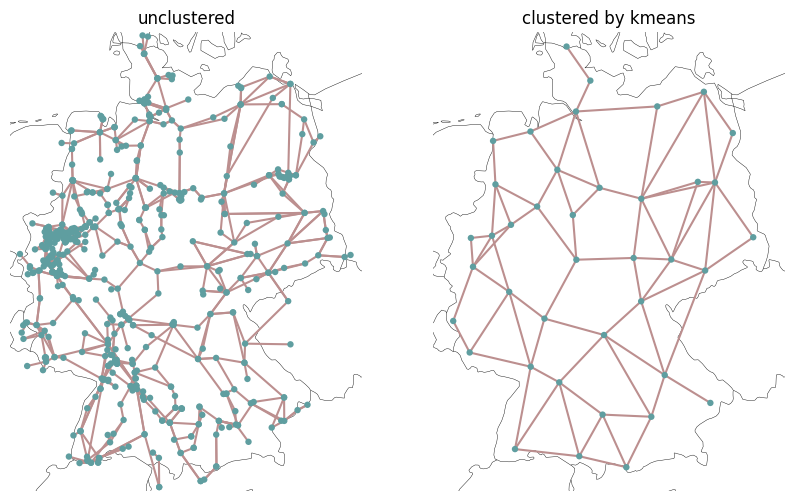

In [463]:
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": crs}, figsize=(10, 7))
n.plot(ax=axs[0], title="unclustered", bus_sizes=0.005, **kwargs)
n_clustered.plot(ax=axs[1], title="clustered by kmeans", bus_sizes=0.005, **kwargs);

We can also assign some weights to the buses, for example, so that low-demand buses are aggregated more strongly:

In [464]:
loads = n.loads_t.p_set.sum().groupby(n.loads.bus).sum().reindex(index=n.buses.index).fillna(1)
n_clustered = n.cluster.cluster_spatially_by_kmeans(bus_weightings=loads, n_clusters=40)

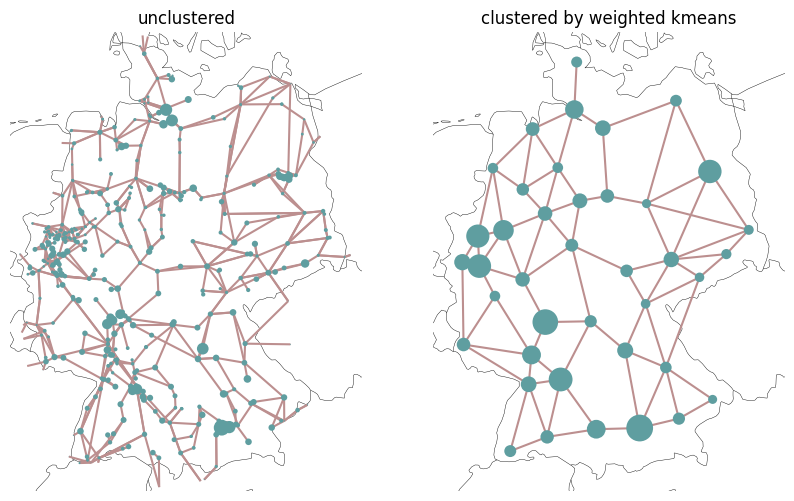

In [465]:
loads_clustered = n_clustered.loads_t.p_set.sum().groupby(n_clustered.loads.bus).sum().reindex(index=n_clustered.buses.index)
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": crs}, figsize=(10, 7))
n.plot(ax=axs[0], title="unclustered", bus_sizes=loads.div(1e6), **kwargs)
n_clustered.plot(ax=axs[1], title="clustered by weighted kmeans", bus_sizes=loads_clustered.div(1e6), **kwargs);

## Hierarchical Clustering

The Hierarchical Agglomerative Clustering (HAC) is a bottom-up approach that initially treats each node as its own cluster. In each iteration two adjacent clusters (e.g. connected by a line or link) are aggregated that have the most similar feature(s) with respect to a given similarity measure. The implementation uses [`sklearn.cluster.AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).

Let's say we want to cluster the buses based on similarity in their solar generation profiles in existing plants (note that in the example dataset there are few solar generators in the central part of Germany).
Then we would prepare the `feature` matrix as follows:

In [466]:
feature = n.generators_t.p_max_pu.filter(like="Solar").T.groupby(n.generators.bus).mean().reindex(n.buses.index).ffill()

n_clustered = n.cluster.cluster_spatially_by_hac(feature=feature, n_clusters=40)

feature.iloc[:5,8:16]

snapshot,2011-01-01 08:00:00,2011-01-01 09:00:00,2011-01-01 10:00:00,2011-01-01 11:00:00,2011-01-01 12:00:00,2011-01-01 13:00:00,2011-01-01 14:00:00,2011-01-01 15:00:00
name,,,,,,,,
1,0.0,0.022246,0.093249,0.138226,0.142156,0.042697,0.014608,0.0
2,0.0,0.022246,0.093249,0.138226,0.142156,0.042697,0.014608,0.0
3,0.0,0.013251,0.022272,0.027736,0.028586,0.023846,0.010311,0.0
4,0.0,0.029535,0.219936,0.272449,0.271843,0.060156,0.021124,0.0
5,0.0,0.029535,0.219936,0.272449,0.271843,0.060156,0.021124,0.0


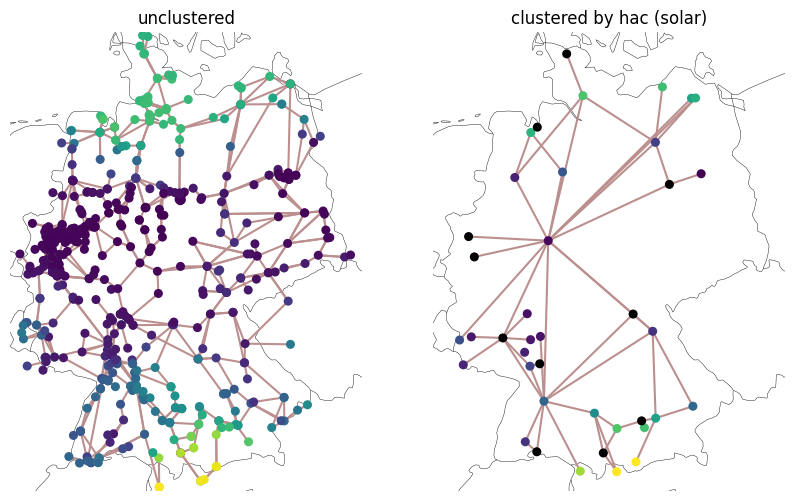

In [467]:
feature_clustered = n_clustered.generators_t.p_max_pu.filter(like="Solar").T.groupby(n_clustered.generators.bus).mean()
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": crs}, figsize=(10, 7))
n.plot(ax=axs[0], title="unclustered", bus_sizes=0.01, bus_colors=feature.mean(axis=1), **kwargs)
n_clustered.plot(ax=axs[1], title="clustered by hac (solar)", bus_sizes=0.01, bus_colors=feature_clustered.mean(axis=1), **kwargs);

## Greedy Modularity Clustering

The greedy modularity clustering approach seeks to find community structures using [`networkx.community.greedy_modularity_communities`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html). The algorithm begins with each node in its own cluster and joins the pair of clusters that most increases [modularity](https://en.wikipedia.org/wiki/Modularity_(networks)). No weights are applied for this algorithm.

In [476]:
n_clustered = n.cluster.cluster_spatially_by_greedy_modularity(n_clusters=80)

## References

For more information, consult the following research papers:

1. Frysztacki, Recht, Brown (2022), [A comparison of clustering methods for the spatial reduction of renewable electricity optimisation models of Europe](https://energyinformatics.springeropen.com/articles/10.1186/s42162-022-00187-7), **Energy Informatics**.

2. Frysztacki, Hörsch, Hagenmeyer, Brown (2021), [The strong effect of network resolution on electricity system models with high shares of wind and solar](https://doi.org/10.1016/j.apenergy.2021.116726), **Applied Energy**.